# Promoter CNN Model (Sequence Only)

A Convolutional Neural Network that predicts component probabilities from promoter sequences.
Chromosome feature has been removed to focus only on sequence information.

This notebook implements a CNN model for predicting component probabilities from DNA promoter sequences, providing an end-to-end solution for:
- Data loading and preprocessing
- Model architecture definition
- Training and validation
- Performance evaluation
- Visualization of results

In [34]:
#!/usr/bin/env python3
"""
Required imports for the CNN model implementation
"""

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"MPS available: {getattr(torch.backends, 'mps', None) is not None and torch.backends.mps.is_available()}")

PyTorch version: 2.6.0
CUDA available: False
MPS available: True


## Data Processing and Dataset Class

The `PromoterDataset` class handles the preprocessing of DNA sequences:
- Encodes DNA sequences into numerical representations
- Converts sequences to one-hot encoding for CNN input
- Handles sequence length standardization

In [35]:
class PromoterDataset(Dataset):
    """Dataset for promoter sequences only"""
    
    def __init__(self, sequences: list, targets: np.ndarray):
        self.sequences = sequences
        self.targets = targets
        
        # DNA encoding dictionary
        self.dna_dict = {'A': 0, 'T': 1, 'G': 2, 'C': 3, 'N': 4}
        
    def __len__(self):
        return len(self.sequences)
    
    def encode_sequence(self, sequence: str, max_length: int = 600) -> np.ndarray:
        """Encode DNA sequence to numerical representation"""
        # Truncate or pad sequence
        if len(sequence) > max_length:
            sequence = sequence[:max_length]
        else:
            sequence = sequence + 'N' * (max_length - len(sequence))
        
        # Convert to numerical encoding
        encoded = np.array([self.dna_dict.get(base.upper(), 4) for base in sequence])
        
        # One-hot encode
        one_hot = np.zeros((max_length, 5))
        one_hot[np.arange(max_length), encoded] = 1
        
        return one_hot.T  # Shape: (5, max_length) for Conv1d
    
    def __getitem__(self, idx):
        sequence = self.encode_sequence(self.sequences[idx])
        target = self.targets[idx].astype(np.float32)
        total = float(np.sum(target))
        if total <= 0:
            target = np.ones_like(target, dtype=np.float32) / target.shape[0]
        else:
            target = target / total
        
        return {
            'sequence': torch.FloatTensor(sequence),
            'target': torch.FloatTensor(target)
        }

## Simple CNN Model Architecture

The `PromoterCNN` class implements a lightweight convolutional neural network:

- **Input**: One-hot encoded DNA sequences (5 channels: A, T, G, C, N)
- **Architecture**: Two simple convolutional blocks + global pooling
- **Output**: 4-component probability distribution (softmax normalized)

This simplified model focuses on fast training while still capturing sequence patterns.

In [ ]:
import torch.nn as nn

class PromoterCNN(nn.Module):
    """CNN for predicting component probabilities with configurable depth."""
    
    def __init__(self, sequence_length: int = 600, num_blocks: int = 2, base_channels: int = 64, dropout: float = 0.3):
        super(PromoterCNN, self).__init__()
        assert num_blocks >= 1
        
        conv_layers = []
        in_ch = 5
        out_ch = base_channels
        for i in range(num_blocks):
            k = 11 if i == 0 else 7
            p = 5 if i == 0 else 3
            conv_layers.append(nn.Conv1d(in_channels=in_ch, out_channels=out_ch, kernel_size=k, padding=p))
            conv_layers.append(nn.ReLU())
            if i < min(2, num_blocks):
                conv_layers.append(nn.MaxPool1d(kernel_size=4))
            conv_layers.append(nn.Dropout(dropout))
            in_ch = out_ch
            out_ch = min(out_ch * 2, base_channels * (2 ** (num_blocks - 1)))
        conv_layers.append(nn.AdaptiveAvgPool1d(1))
        self.sequence_conv = nn.Sequential(*conv_layers)
        
        final_ch = in_ch
        hidden = max(32, final_ch // 2)
        self.classifier = nn.Sequential(
            nn.Linear(final_ch, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 4)
        )
        
    def forward(self, sequence):
        x = self.sequence_conv(sequence)
        x = x.squeeze(-1)
        logits = self.classifier(x)
        return logits


## Data Loading and Preparation

Functions for loading the processed data and preparing it for training:

In [37]:
def load_and_prepare_data(file_path: str) -> Tuple[list, np.ndarray]:
    """Load and prepare data for training"""
    print("Loading data...")
    df = pd.read_csv(file_path)
    
    # Component probabilities as targets
    prob_cols = ['Component_1_Probability', 'Component_2_Probability', 
                'Component_3_Probability', 'Component_4_Probability']
    
    # Filter out rows with missing sequence data or target data
    print(f"Initial data shape: {df.shape}")
    
    # Remove rows with NaN in ProSeq column
    df = df.dropna(subset=['ProSeq'])
    print(f"After removing missing sequences: {df.shape}")
    
    # Remove rows with NaN in any probability column
    df = df.dropna(subset=prob_cols)
    print(f"After removing missing probabilities: {df.shape}")
    
    # Extract features and targets
    sequences = df['ProSeq'].tolist()
    targets = df[prob_cols].values
    
    # Additional validation - ensure all sequences are strings
    valid_sequences = []
    valid_targets = []
    
    for i, seq in enumerate(sequences):
        if isinstance(seq, str) and len(seq) > 0:
            valid_sequences.append(seq)
            valid_targets.append(targets[i])
    
    sequences = valid_sequences
    targets = np.array(valid_targets)
    
    print(f"Final dataset: {len(sequences)} samples")
    print(f"Average sequence length: {np.mean([len(seq) for seq in sequences]):.1f}")
    print(f"Min sequence length: {min([len(seq) for seq in sequences])}")
    print(f"Max sequence length: {max([len(seq) for seq in sequences])}")
    
    return sequences, targets

## Training and Validation Functions

Functions for training and validating the model:

In [38]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0.0
    
    for batch in train_loader:
        sequences = batch['sequence'].to(device)
        targets = batch['target'].to(device)
        
        optimizer.zero_grad()
        logits = model(sequences)
        log_probs = F.log_softmax(logits, dim=1)
        loss = criterion(log_probs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def validate_epoch(model, val_loader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        for batch in val_loader:
            sequences = batch['sequence'].to(device)
            targets = batch['target'].to(device)
            
            logits = model(sequences)
            log_probs = F.log_softmax(logits, dim=1)
            loss = criterion(log_probs, targets)
            total_loss += loss.item()
    
    return total_loss / len(val_loader)

def evaluate_model(model, test_loader, device):
    """Evaluate the trained model"""
    model.eval()
    
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch in test_loader:
            sequences = batch['sequence'].to(device)
            targets = batch['target'].to(device)
            
            logits = model(sequences)
            probs = torch.softmax(logits, dim=1)
            
            all_predictions.append(probs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    
    predictions = np.vstack(all_predictions)
    targets = np.vstack(all_targets)
    
    return predictions, targets

## Visualization and Results Analysis

Functions for plotting training results and model performance:

In [39]:
def plot_results(train_losses, val_losses, metrics, predictions, targets):
    """Plot training results and model performance"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Training curves
    axes[0, 0].plot(train_losses, label='Train Loss', color='blue', alpha=0.7)
    axes[0, 0].plot(val_losses, label='Validation Loss', color='red', alpha=0.7)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss (MSE)')
    axes[0, 0].set_title('Training Curves')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # R2 scores by component
    component_names_short = ['Comp_1', 'Comp_2', 'Comp_3', 'Comp_4']
    r2_scores = [metrics[f'Component_{i+1}']['R2'] for i in range(4)]
    colors = ['blue', 'orange', 'green', 'red']
    
    axes[0, 1].bar(component_names_short, r2_scores, color=colors, alpha=0.7)
    axes[0, 1].set_ylabel('R² Score')
    axes[0, 1].set_title('R² Scores by Component')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim(0, 1)
    
    # MSE by component
    mse_scores = [metrics[f'Component_{i+1}']['MSE'] for i in range(4)]
    
    axes[0, 2].bar(component_names_short, mse_scores, color=colors, alpha=0.7)
    axes[0, 2].set_ylabel('MSE')
    axes[0, 2].set_title('MSE by Component')
    axes[0, 2].grid(True, alpha=0.3)
    
    # Prediction vs actual scatter plots for each component
    for i in range(3):
        row = 1
        col = i
        
        axes[row, col].scatter(targets[:, i], predictions[:, i], alpha=0.5, s=10, color=colors[i])
        axes[row, col].plot([0, 1], [0, 1], 'r--', alpha=0.8)
        axes[row, col].set_xlabel('Actual Probability')
        axes[row, col].set_ylabel('Predicted Probability')
        axes[row, col].set_title(f'Component {i+1} (R² = {metrics[f"Component_{i+1}"]["R2"]:.3f})')
        axes[row, col].grid(True, alpha=0.3)
        axes[row, col].set_xlim(0, 1)
        axes[row, col].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig('cnn_results.png', dpi=300, bbox_inches='tight')
    plt.show()

## Prediction Function

Function for making predictions on new sequences:

In [40]:
def predict_component_probabilities(model, sequence: str, device) -> dict:
    """Predict component probabilities for a new sequence"""
    
    model.eval()
    
    # Create temporary dataset for encoding
    temp_dataset = PromoterDataset([sequence], np.array([[0, 0, 0, 0]], dtype=np.float32))
    
    # Encode sequence
    encoded_seq = temp_dataset.encode_sequence(sequence)
    
    # Convert to tensor
    sequence_tensor = torch.FloatTensor(encoded_seq).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        logits = model(sequence_tensor)
        probs = torch.softmax(logits, dim=1)
    
    probabilities = probs.cpu().numpy()[0]
    predicted_component = int(np.argmax(probabilities) + 1)
    confidence = float(np.max(probabilities))
    
    return {
        'component_1_prob': float(probabilities[0]),
        'component_2_prob': float(probabilities[1]),
        'component_3_prob': float(probabilities[2]),
        'component_4_prob': float(probabilities[3]),
        'predicted_component': predicted_component,
        'confidence': confidence,
        'interpretation': f"Predicted Component {predicted_component} with {confidence:.1%} confidence"
    }

## Main Execution Pipeline

Now let's run the complete training and evaluation pipeline:

In [41]:
# Load data
sequences, targets = load_and_prepare_data('../../Processed-Data/ProSeq_with_4component_analysis.csv')

# Show data statistics
print(f"\nData statistics:")
print(f"Total samples: {len(sequences)}")
print(f"Target shape: {targets.shape}")
for i in range(4):
    print(f"  Component {i+1}: {targets[:, i].min():.4f} - {targets[:, i].max():.4f} (mean: {targets[:, i].mean():.4f})")

Loading data...
Initial data shape: (8739, 15)
After removing missing sequences: (8735, 15)
After removing missing probabilities: (8735, 15)
Final dataset: 8735 samples
Average sequence length: 600.0
Min sequence length: 472
Max sequence length: 600

Data statistics:
Total samples: 8735
Target shape: (8735, 4)
  Component 1: 0.0000 - 0.9278 (mean: 0.4332)
  Component 2: 0.0000 - 1.0000 (mean: 0.0967)
  Component 3: 0.0000 - 1.0000 (mean: 0.1887)
  Component 4: 0.0000 - 0.9746 (mean: 0.2814)


In [42]:
# Split data (stratified by dominant component)
labels = np.argmax(targets, axis=1)
train_seq, test_seq, train_targets, test_targets = train_test_split(
    sequences, targets, test_size=0.2, random_state=42, stratify=labels
)

train_labels = np.argmax(train_targets, axis=1)
train_seq, val_seq, train_targets, val_targets = train_test_split(
    train_seq, train_targets, test_size=0.2, random_state=42, stratify=train_labels
)

print(f"\nData splits:")
print(f"  Train: {len(train_seq)}, Val: {len(val_seq)}, Test: {len(test_seq)}")

# Create datasets
train_dataset = PromoterDataset(train_seq, train_targets)
val_dataset = PromoterDataset(val_seq, val_targets)
test_dataset = PromoterDataset(test_seq, test_targets)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


Data splits:
  Train: 5590, Val: 1398, Test: 1747


In [ ]:
# Create model
model_depth = 2  # change this to 1, 2, or 3 to set the number of conv blocks
base_channels = 20  # ~8k-9k params for ~9000 datapoints
model = PromoterCNN(num_blocks=model_depth, base_channels=base_channels)

if getattr(torch.backends, 'mps', None) is not None and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"\nModel created with {total_params:,} parameters (depth={model_depth}, base_channels={base_channels})")
print(f"Training on: {device}")

# Training configuration
num_epochs = 100
learning_rate = 1e-3

criterion = nn.KLDivLoss(reduction='batchmean')
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=8, factor=0.5, verbose=True)


Model created with 69,572 parameters
Training on: mps


In [44]:
# Training loop
train_losses = []
val_losses = []
best_val_loss = float('inf')
bad_epochs = 0
max_bad_epochs = 15

print(f"\nStarting training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss = validate_epoch(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Store losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Save best model
    if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        bad_epochs = 0
        torch.save(model.state_dict(), 'best_promoter_cnn.pth')
    else:
        bad_epochs += 1
        if bad_epochs >= max_bad_epochs:
            print(f"Early stopping at epoch {epoch+1}. Best Val Loss: {best_val_loss:.6f}")
            break
    
    # Print progress and LR
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch [{epoch+1:3d}/{num_epochs}] - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, LR: {current_lr:.2e}')


Starting training for 100 epochs...
Epoch [  1/100] - Train Loss: 0.903504, Val Loss: 0.889462, LR: 1.00e-03
Epoch [  2/100] - Train Loss: 0.893173, Val Loss: 0.893821, LR: 1.00e-03
Epoch [  3/100] - Train Loss: 0.892152, Val Loss: 0.893799, LR: 1.00e-03
Epoch [  4/100] - Train Loss: 0.892711, Val Loss: 0.890467, LR: 1.00e-03
Epoch [  5/100] - Train Loss: 0.891844, Val Loss: 0.886774, LR: 1.00e-03
Epoch [  6/100] - Train Loss: 0.888230, Val Loss: 0.886569, LR: 1.00e-03
Epoch [  7/100] - Train Loss: 0.890838, Val Loss: 0.889879, LR: 1.00e-03
Epoch [  8/100] - Train Loss: 0.887802, Val Loss: 0.889758, LR: 1.00e-03
Epoch [  9/100] - Train Loss: 0.888618, Val Loss: 0.887552, LR: 1.00e-03
Epoch [ 10/100] - Train Loss: 0.886459, Val Loss: 0.887416, LR: 1.00e-03
Epoch [ 11/100] - Train Loss: 0.888208, Val Loss: 0.887022, LR: 1.00e-03
Epoch [ 12/100] - Train Loss: 0.888935, Val Loss: 0.886813, LR: 1.00e-03
Epoch [ 13/100] - Train Loss: 0.887473, Val Loss: 0.886186, LR: 1.00e-03
Epoch [ 14/100

In [45]:
# Load best model and evaluate
model.load_state_dict(torch.load('best_promoter_cnn.pth', map_location=device))
predictions, targets = evaluate_model(model, test_loader, device)

# Calculate metrics
component_names = ['Component_1', 'Component_2', 'Component_3', 'Component_4']
metrics = {}

print(f"\n" + "="*50)
print("MODEL EVALUATION RESULTS")
print("="*50)

for i, comp_name in enumerate(component_names):
    mse = mean_squared_error(targets[:, i], predictions[:, i])
    r2 = r2_score(targets[:, i], predictions[:, i])
    
    metrics[comp_name] = {'MSE': mse, 'R2': r2}
    print(f"{comp_name}: MSE = {mse:.6f}, R² = {r2:.4f}")

# Overall metrics
overall_mse = mean_squared_error(targets, predictions)
overall_r2 = r2_score(targets.flatten(), predictions.flatten())

metrics['Overall'] = {'MSE': overall_mse, 'R2': overall_r2}
print(f"\nOverall: MSE = {overall_mse:.6f}, R² = {overall_r2:.4f}")


MODEL EVALUATION RESULTS
Component_1: MSE = 0.157636, R² = 0.0051
Component_2: MSE = 0.068682, R² = 0.0026
Component_3: MSE = 0.092275, R² = 0.0313
Component_4: MSE = 0.154494, R² = 0.0066

Overall: MSE = 0.118272, R² = 0.1226


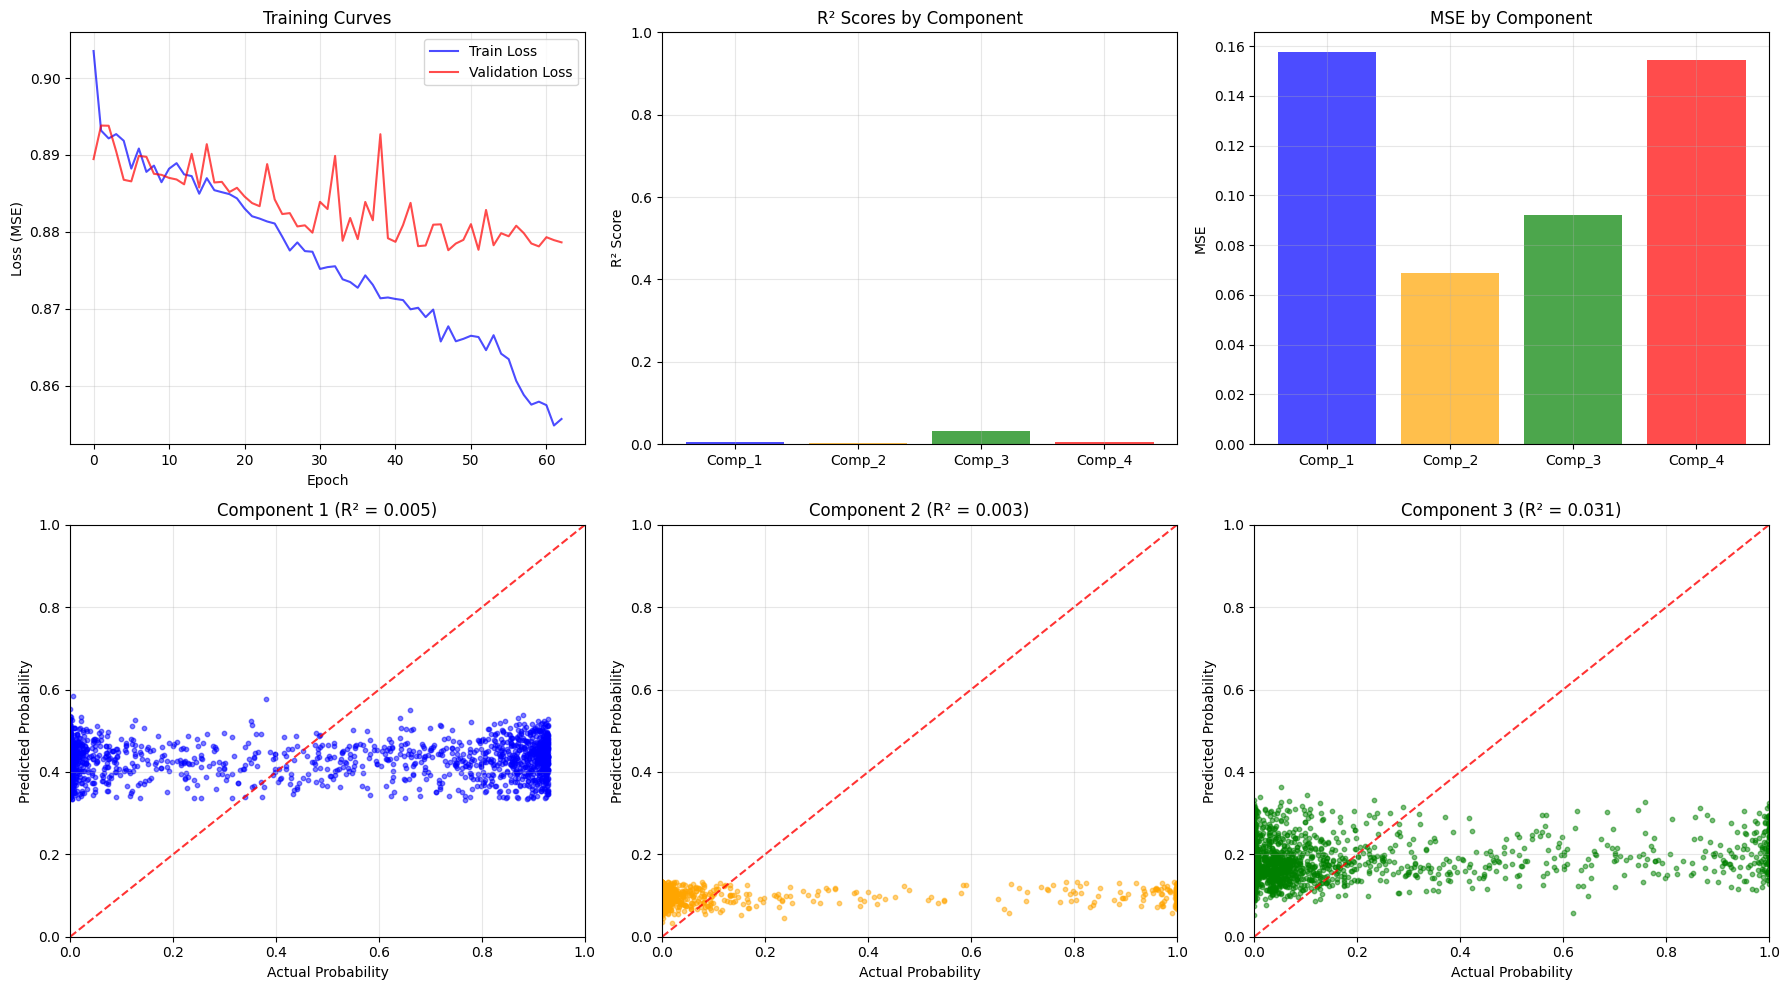

In [46]:
# Plot results
plot_results(train_losses, val_losses, metrics, predictions, targets)

In [47]:
# Test prediction function
print(f"\n" + "="*50)
print("TESTING PREDICTION FUNCTION")
print("="*50)

sample_seq = sequences[0]
sample_target = targets[0]

result = predict_component_probabilities(model, sample_seq, device)

print(f"Sample sequence length: {len(sample_seq)}")
print(f"Actual probabilities: {sample_target}")
print(f"\nCNN Predictions:")
for i in range(4):
    pred_key = f'component_{i+1}_prob'
    print(f"  Component {i+1}: {result[pred_key]:.4f} (actual: {sample_target[i]:.4f})")

print(f"\n{result['interpretation']}")
print(f"Actual component: {np.argmax(sample_target) + 1}")

print(f"\nModel saved as 'best_promoter_cnn.pth'")
print(f"Results plot saved as 'cnn_results.png'")


TESTING PREDICTION FUNCTION
Sample sequence length: 600
Actual probabilities: [8.8614717e-02 2.4386914e-08 9.1138309e-01 2.1360195e-06]

CNN Predictions:
  Component 1: 0.4802 (actual: 0.0886)
  Component 2: 0.0785 (actual: 0.0000)
  Component 3: 0.1317 (actual: 0.9114)
  Component 4: 0.3096 (actual: 0.0000)

Predicted Component 1 with 48.0% confidence
Actual component: 3

Model saved as 'best_promoter_cnn.pth'
Results plot saved as 'cnn_results.png'


In [ ]:
# Run a small search for optimal depth relative to dataset size
num_datapoints = len(train_seq) + len(val_seq) + len(test_seq)
print(f"Total datapoints: {num_datapoints}")

# Parameter budgets as multiples of N (common heuristic: params ~ 0.5–2x N)
depths = [1, 2, 3]
ratios = [0.5, 1.0, 2.0]

results = search_optimal_depth(num_datapoints=num_datapoints, depths=depths, ratios=ratios)

print("\nTop candidates:")
for row in results[:5]:
    print(row)

best = results[0]
print(f"\nSelected depth={best['depth']}, base_channels={best['base_channels']} (params={best['params']}, ratio={best['ratio']}) with val_loss={best['val_loss']:.6f}")
